# Overview
The goal of this project is to perform classification of written media as misinformation or not.


## Fetch Data
The [notebook](./index.ipynb) uses a [script](./download_datasets.sh) to automatically fetch the data for the project. It can be run manually to inspect the data beforehand by executing the following command:
```bash
chmod +x download_datasets.sh
sh download_datasets.sh
```

In [44]:
# fetch data using ./download_datasets.sh
!bash ./download_datasets.sh

Checking and downloading datasets...
✔ fake-news-classification.zip already exists. Skipping download.
✔ fake-and-real-news-dataset.zip already exists. Skipping download.
Extracting Kaggle datasets...
✔ liar_dataset.zip already exists. Skipping download.
✔ All datasets are ready!


## setup for NLP tools
In order to make full use of our NLP tooling we will install:
- `punkt` for tokenization 
- `stopwords` for removing common words
- `wordnet` for lemmatization
- `averaged_perceptron_tagger` for part of speech tagging
- `maxent_ne_chunker` for named entity recognition
- `words` for named entity recognition
- `spacy` for named entity recognition
- `en_core_web_sm` for named entity recognition
```bash

In [45]:
!python -m nltk.downloader punkt stopwords wordnet averaged_perceptron_tagger
!python -m spacy download en_core_web_sm

/Users/rob/micromamba/envs/fake-news/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /Users/rob/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/rob/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/rob/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rob/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 38.5 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_co

# Project

In [46]:
# project imports
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy

import re

from wordcloud import WordCloud
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import string
from sklearn.model_selection import GridSearchCV


# Data Preprocessing
The data is loaded, inspected, and assembled into a singular dataframe. The data is then preprocessed by removing stopwords, punctuation, and lemmatizing the text. The data is then split into training and testing sets.

## Loading Data
The data is sourced from three different datasets:
- [Fake & Real News]()
- [Fake News Classification]()
- [Liar Dataset]()

The data is loaded, inspected, and assembled into a singular dataframe.

### Define Data Paths

In [47]:
# define datasets paths
datasets = {
    "fake_and_real_news": {
        "fake": "datasets/fake-and-real-news/Fake.csv",
        "real": "datasets/fake-and-real-news/True.csv"
    },
    "fake_news_classification": {
        "train": "datasets/fake-news-classification/train (2).csv",
        "test": "datasets/fake-news-classification/test (1).csv",
        "evaluation": "datasets/fake-news-classification/evaluation.csv"
    },
    "liar_data": {
        "train": "datasets/liar_data/train.tsv",
        "test": "datasets/liar_data/test.tsv",
        "valid": "datasets/liar_data/valid.tsv"
    }
}



### Loading the Fake & Real News Dataset

In [48]:

# Load Fake & Real News Dataset
df_fake = pd.read_csv(datasets["fake_and_real_news"]["fake"])
df_real = pd.read_csv(datasets["fake_and_real_news"]["real"])

# Assign labels
df_fake["label"] = "fake"
df_real["label"] = "real"

# Standardize column names
df_fake.rename(columns={"title": "headline", "text": "content"}, inplace=True)
df_real.rename(columns={"title": "headline", "text": "content"}, inplace=True)

# Merge Fake & Real News
df_news = pd.concat([df_fake, df_real], ignore_index=True)

# drop columns
df_news.drop(columns=["subject", "date", "headline"], inplace=True)

# rename content to text
df_news.rename(columns={"content": "text"}, inplace=True)

# drop rows with missing labels
df_news.dropna(subset=["label"], inplace=True)

# encode labels
df_news["label"] = df_news["label"].map({"fake": 1, "real": 0})

# print columns
print(df_news.columns)

Index(['text', 'label'], dtype='object')


### Loading the Fake News Classification Dataset

In [49]:
# Load Fake News Classification Dataset with explicit delimiter
df_train = pd.read_csv(datasets["fake_news_classification"]["train"], delimiter=';')
df_test = pd.read_csv(datasets["fake_news_classification"]["test"], delimiter=';')
df_evaluation = pd.read_csv(datasets["fake_news_classification"]["evaluation"], delimiter=';')

# Merge train, test, and evaluation datasets
df_fake_news_class = pd.concat([df_train, df_test, df_evaluation], ignore_index=True)


# drop columns
df_fake_news_class.drop(columns=['Unnamed: 0', 'title'], inplace=True)

# drop rows with missing labels
df_fake_news_class.dropna(subset=["label"], inplace=True)

# encode labels
df_fake_news_class["label"] = df_fake_news_class["label"].map({"fake": 1, "real": 0})

# print columns
print(df_fake_news_class.columns)

Index(['text', 'label'], dtype='object')


### Loading the Liar Dataset

In [50]:
# # Define correct column names (LIAR dataset has 14 columns)
# columns = ["id", "label", "statement", "subject", "speaker", "job", "state", "party",
#            "venue", "barely-true", "false", "half-true", "mostly-true", "pants-fire", "context"]

# # Load datasets with correct delimiter and column assignment
# df_liar_train = pd.read_csv(datasets["liar_data"]["train"], delimiter='\t', names=columns, header=None)
# df_liar_test = pd.read_csv(datasets["liar_data"]["test"], delimiter='\t', names=columns, header=None)
# df_liar_valid = pd.read_csv(datasets["liar_data"]["valid"], delimiter='\t', names=columns, header=None)

# # Combine datasets
# df_liar = pd.concat([df_liar_train, df_liar_test, df_liar_valid], ignore_index=True)

# # Map multi-class labels to binary labels
# label_mapping = {
#     "pants-fire": "fake",
#     "false": "fake",
#     "barely-true": "fake",
#     "half-true": "real",
#     "mostly-true": "real",
#     "true": "real"
# }
# df_liar["label"] = df_liar["label"].map(label_mapping)

# # Rename "statement" → "content" to match other datasets
# df_liar.rename(columns={"statement": "content"}, inplace=True)

# # Drop unnecessary columns
# columns_to_drop = ["id", "speaker", "job", "state", "subject", "party", "venue", 
#                    "barely-true", "false", "half-true", "mostly-true", "pants-fire", "context"]
# df_liar.drop(columns=columns_to_drop, inplace=True)

# # standardize column names
# df_liar.rename(columns={"content": "text"}, inplace=True)

# drop rows with missing labels
# df_liar.dropna(subset=["label"], inplace=True)

# # map binary labels to 0 and 1
# df_liar["label"] = df_liar["label"].map({"fake": 1, "real": 0})

# # print dataset info
# print(df_liar.head())
# print(df_liar["label"].value_counts())
# print(df_liar.columns)


### Assemble Data
Here we assemble the data into a singular dataframe. This will involve renaming columns, dropping unnecessary columns, and adding a label column. Importantly we will set our target variable to be binary, with 1 representing misinformation and 0 representing accurate information.

In [83]:
# merge datasets and drop duplicates
df = pd.concat([
    df_news, 
    df_fake_news_class, 
    # df_liar
    ], ignore_index=True).drop_duplicates()

# drop rows with missing text
df.dropna(subset=["text"], inplace=True)

# drop rows with missing labels
df.dropna(subset=["label"], inplace=True)

# check standardized label distribution
print(f"label distribution: {df['label'].value_counts()}")

# check number of rows
print(f"rows: {df.shape[0]}")

# check columns
print(f"columns: {df.columns}")

# check for missing values
print(f"nulls: {df.isnull().sum()}")

# check for duplicates
print(f"duplicates: {df.duplicated().sum()}")

# check for empty strings
print(f"empty strings: {df['text'].str.strip().eq('').sum()}")

label distribution: label
0.0    21192
1.0    17455
Name: count, dtype: int64
rows: 38647
columns: Index(['text', 'label'], dtype='object')
nulls: text     0
label    0
dtype: int64
duplicates: 0
empty strings: 3


# Data Preprocessing
Our preprocessing steps will involve
- removing stopwords
- removing punctuation
- lemmatization (converting words to their base form)
- removing special characters, numbers, and extra spaces
- converting text to lowercase

## Removing Special Characters (numbers, punctuation, etc.)

In [52]:
# remove empty strings
df = df[df["text"].str.strip() != ""]  

def clean_text(text):
    '''
    function to format and clean text by lowercasing text, removing URLs, numbers, and punctuation. 
    '''
    text = text.lower() 
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# apply text cleaning function to text column
df["text"] = df["text"].apply(clean_text)

## Remove Stopwords
Stopwords are common words that do not add much meaning (i.e. articles, prepositions, etc.) to a sentence and can safely be removed.

In [53]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

# apply remove_stopwords function to text column
df["text"] = df["text"].apply(remove_stopwords)

## Lemmatization
This process reduces words to their base form (e.g., "running" → "run") which can help reduce the complexity of the data and improve the performance of our models.

In [54]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

# apply lemmatize_text function to text column
df["text"] = df["text"].apply(lemmatize_text)

## Shuffle data
We shuffle the data to ensure that the model does not learn the order of the data.

In [55]:
# shuffle the order of rows in the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Exploratory Data Analysis
We perform some basic exploratory data analysis to better understand the data we are working with. This includes visualizing the distribution of classes, the length of the text, and the most common words in the dataset.

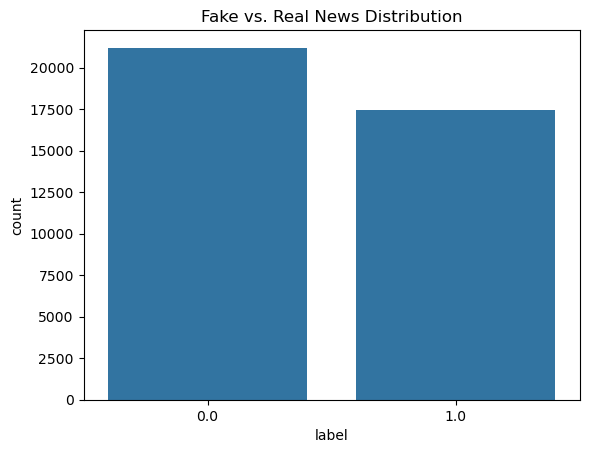

<Figure size 640x480 with 0 Axes>

In [56]:
# plot the distribution of labels
sns.countplot(x=df['label'])
plt.title("Fake vs. Real News Distribution")
plt.show()
plt.savefig("./images/real_fake_distribution.png")

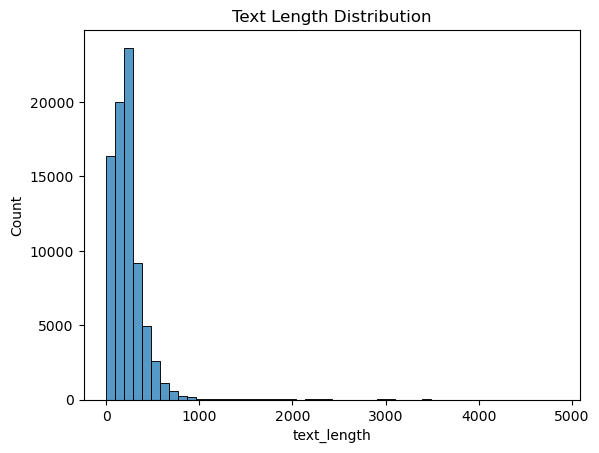

<Figure size 640x480 with 0 Axes>

In [57]:
# text length distribution
df["text_length"] = df["text"].apply(lambda x: len(str(x).split()))
sns.histplot(df["text_length"], bins=50)
plt.title("Text Length Distribution")
plt.show()
plt.savefig("./images/text_len_distribution.png")

### Word Cloud of Most Common Words (Raw Frequency)

In [58]:
def generate_wordcloud(df, label, stop_words, title="Word Cloud", colormap="coolwarm", save_path=None, use_tfidf=False, ngram_range=(1,2)):
    """
    Generates and displays a word cloud for a given label in the dataset.
    
    Parameters:
    - df: DataFrame containing text data.
    - label: The label to filter the text (1 for Fake, 0 for Real).
    - stop_words: Set of stop words to exclude.
    - title: Title of the word cloud plot.
    - colormap: Color scheme for the word cloud visualization.
    - save_path: If provided, saves the word cloud image to this file.
    - use_tfidf: If True, generates a word cloud based on TF-IDF weighted words.
    - ngram_range: Tuple specifying the range of n-grams to include.
    
    Returns:
    - Displays the word cloud.
    """
    # Ensure text column is clean
    text_series = df[df["label"] == label]["text"].dropna().astype(str)  # Drop NaNs and convert to strings
    text_series = text_series[text_series.str.strip() != ""]  # Remove empty strings
    
    if use_tfidf:
        # Compute TF-IDF scores
        vectorizer = TfidfVectorizer(stop_words="english", max_features=5000, ngram_range=ngram_range)  # Limit vocab size
        tfidf_matrix = vectorizer.fit_transform(text_series)
        feature_names = np.array(vectorizer.get_feature_names_out())

        # Compute average TF-IDF score per word
        tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
        word_freqs = dict(zip(feature_names, tfidf_scores))

        # Generate word cloud using TF-IDF weights
        wordcloud = WordCloud(
            width=800, height=800,
            background_color='white',
            colormap=colormap
        ).generate_from_frequencies(word_freqs)

    else:
        # Use raw text frequency
        text = " ".join(text_series)
        wordcloud = WordCloud(
            width=800, height=800,
            background_color='white',
            stopwords=stop_words,
            colormap=colormap,
            min_font_size=10
        ).generate(text)

    # Plot word cloud
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.tight_layout(pad=0)

    # Save image if save_path is provided
    if save_path:
        wordcloud.to_file(save_path)
        print(f"Word cloud saved to {save_path}")

    plt.show()

Word cloud saved to ./images/fake_news_wordcloud_raw.png


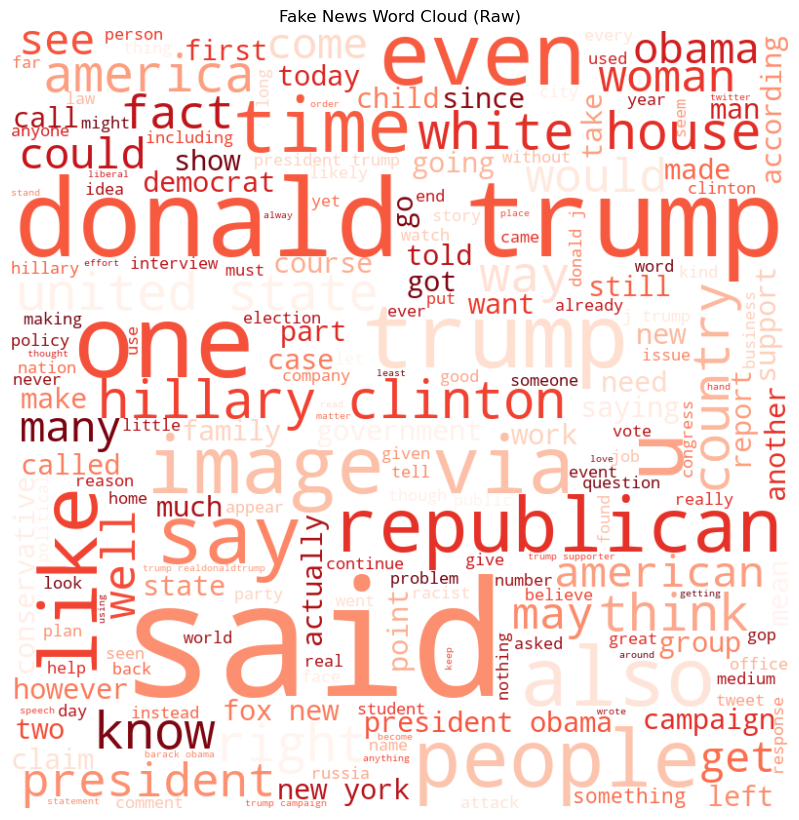

Word cloud saved to ./images/real_news_wordcloud_raw.png


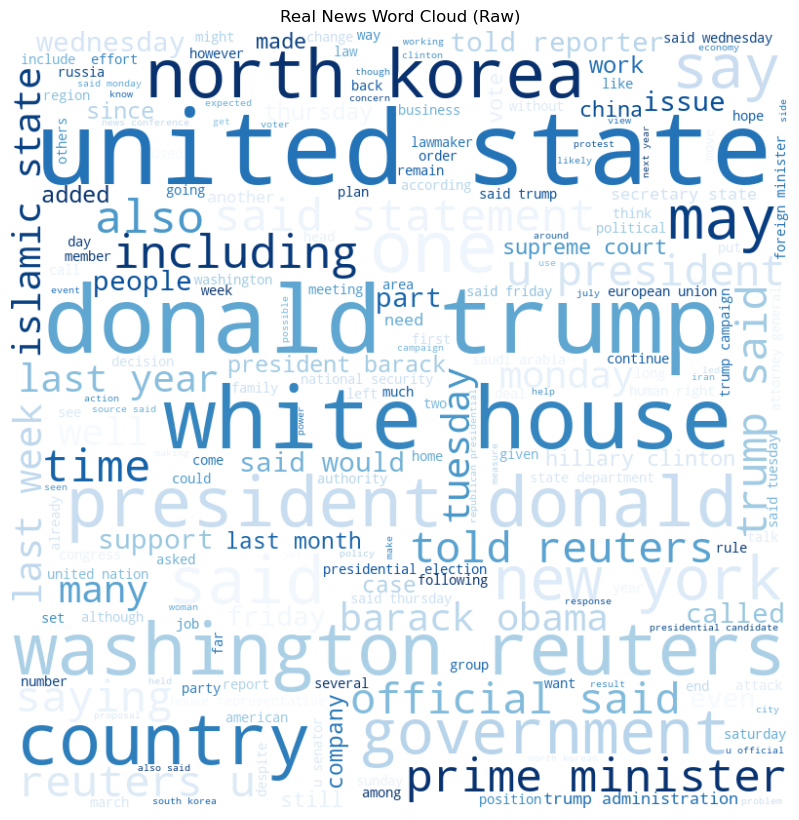

In [59]:
generate_wordcloud(df, 1, stop_words, title="Fake News Word Cloud (Raw)", colormap="Reds", save_path="./images/fake_news_wordcloud_raw.png")
generate_wordcloud(df, 0, stop_words, title="Real News Word Cloud (Raw)", colormap="Blues", save_path="./images/real_news_wordcloud_raw.png")

### Word Cloud of Most Common Words (Normalized Frequency)

Word cloud saved to ./images/fake_news_wordcloud_normalized.png


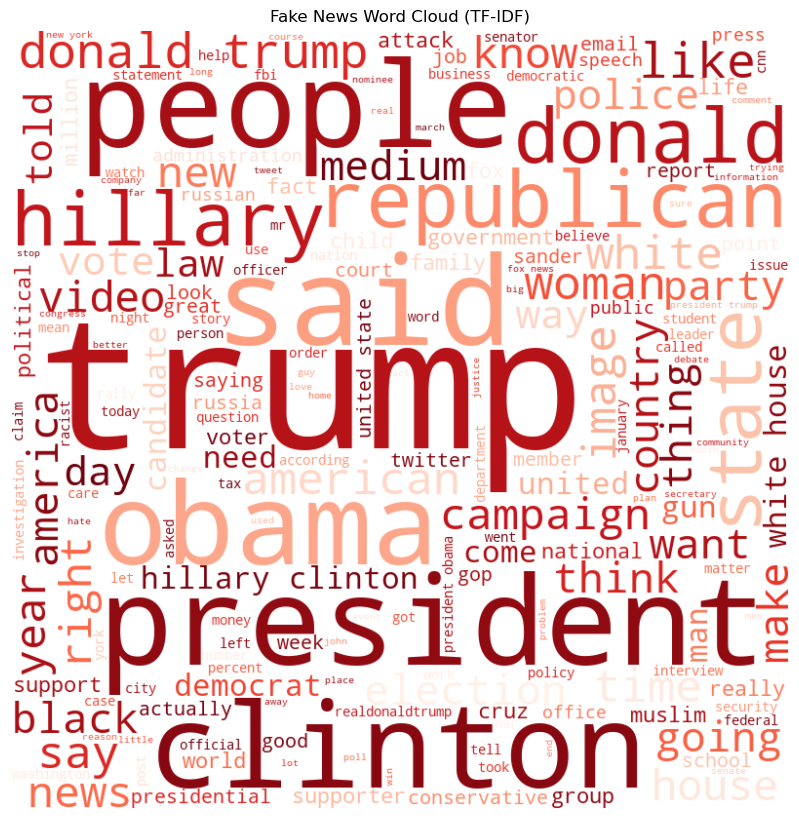

Word cloud saved to ./images/real_news_wordcloud_normalized.png


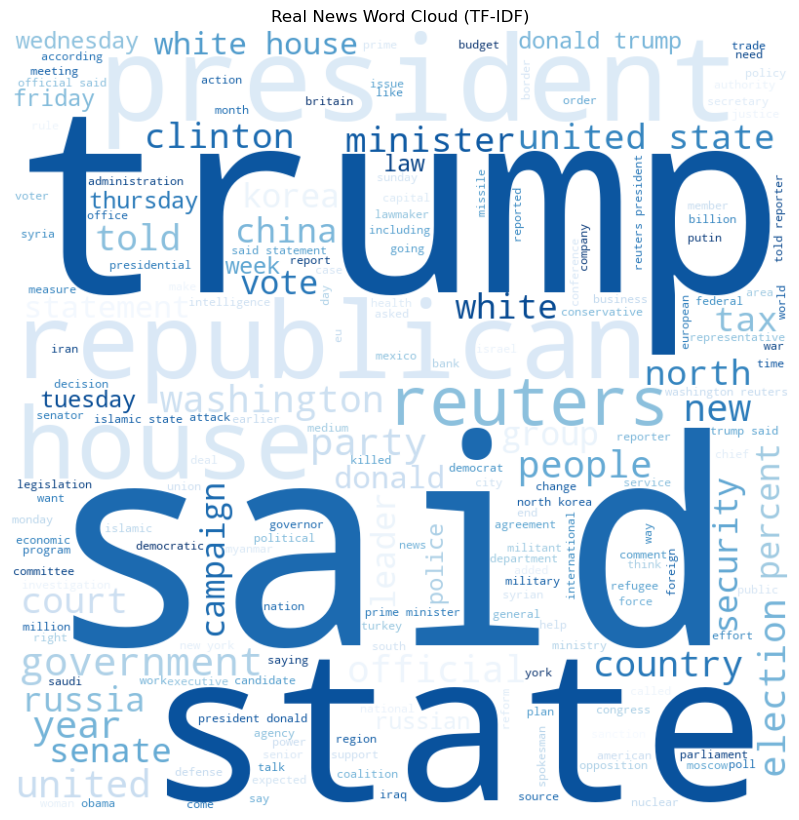

In [60]:
generate_wordcloud(df, 1, stop_words, title="Fake News Word Cloud (TF-IDF)", colormap="Reds", use_tfidf=True, save_path="./images/fake_news_wordcloud_normalized.png")
generate_wordcloud(df, 0, stop_words, title="Real News Word Cloud (TF-IDF)", colormap="Blues", use_tfidf=True, save_path="./images/real_news_wordcloud_normalized.png")

In [61]:
# check for missing values and empty strings
print(df.isnull().sum())
print(df[df["text"] == ""])

text               0
label          40583
text_length        0
dtype: int64
      text  label  text_length
842           1.0            0
1261          1.0            0
1837          1.0            0
1972          1.0            0
2319          1.0            0
...    ...    ...          ...
76565         1.0            0
76832         NaN            0
77179         1.0            0
78027         1.0            0
79072         NaN            0

[108 rows x 3 columns]


### Venn diagram of most common words in fake and real news

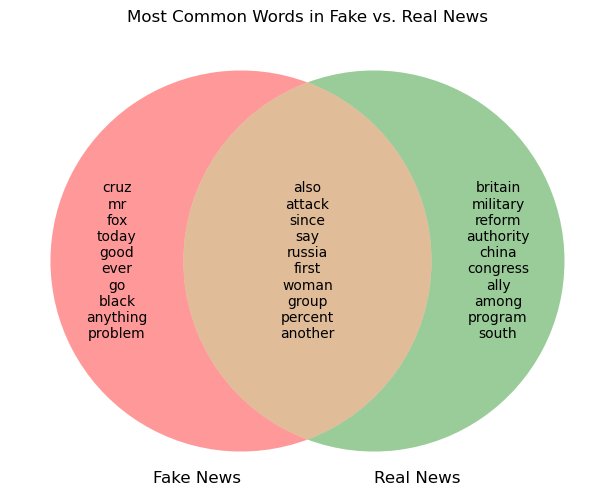

In [62]:
# function to get the most common words
def get_most_common_words(texts, top_n=100, exclude_words=None):
    """
    Get the most common words from a list of texts.

    Parameters:
    - texts: Series or list of text data.
    - top_n: Number of most common words to return.
    - exclude_words: Set of words to exclude from the results.

    Returns:
    - A set of the most common words.
    """
    words = " ".join(texts).lower().split()
    words = [word.strip(string.punctuation) for word in words]  # Remove punctuation
    word_counts = Counter(words)

    if exclude_words:
        word_counts = {word: count for word, count in word_counts.items() if word not in exclude_words}

    return set(word for word, _ in Counter(word_counts).most_common(top_n))

# function to plot a wenn diagram of the most common words in fake and real news
def plot_venn_diagram(df, label_col="label", text_col="text", common_filter_size=5, top_n=50, save_path=None):
    """
    Creates a Venn diagram comparing the most common words in fake vs. real news.

    Parameters:
    - df: DataFrame containing the data.
    - label_col: Column name for labels (0 for Real, 1 for Fake).
    - text_col: Column name containing text data.
    - common_filter_size: Number of most common words to exclude globally.
    - top_n: Number of most frequent words to consider in each category.
    - save_path: If provided, saves the plot to this file.

    Displays:
    - A Venn diagram showing the most frequent words in Fake vs. Real news.
    """
    overall_counts = Counter(" ".join(df[text_col]).lower().split())
    most_frequent_words = {word for word, _ in overall_counts.most_common(common_filter_size)}

    fake_words = get_most_common_words(df[df[label_col] == 1][text_col], top_n, most_frequent_words)
    real_words = get_most_common_words(df[df[label_col] == 0][text_col], top_n, most_frequent_words)

    # find common and unique words
    common_words = fake_words.intersection(real_words)
    unique_fake_words = fake_words - common_words
    unique_real_words = real_words - common_words

    # plot Venn diagram
    plt.figure(figsize=(8, 6))
    venn = venn2([fake_words, real_words], ("Fake News", "Real News"))

    # customize labels: Show top words in each section
    venn.get_label_by_id("10").set_text("\n".join(list(unique_fake_words)[:10]))
    venn.get_label_by_id("01").set_text("\n".join(list(unique_real_words)[:10]))
    venn.get_label_by_id("11").set_text("\n".join(list(common_words)[:10]))

    plt.title("Most Common Words in Fake vs. Real News")
    plt.show()

plot_venn_diagram(df, top_n=200, save_path="./images/venn_raw.png")

### Plot Wenn diagram (Normalized Frequency)

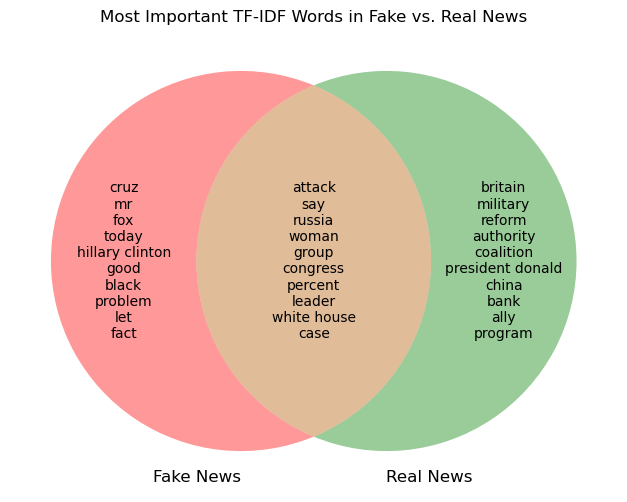

In [ ]:
def get_top_tfidf_words(texts, top_n=50, exclude_words=None, ngram_range=(1, 3)):
    """
    Get the top TF-IDF weighted words from a list of texts.

    Parameters:
    - texts: Series or list of text data.
    - top_n: Number of most important words to return.
    - exclude_words: Set of words to exclude from the results.

    Returns:
    - A set of the most important words based on TF-IDF.
    """
    vectorizer = TfidfVectorizer(stop_words="english", ngram_range=ngram_range)
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Compute average TF-IDF score for each word
    tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()

    # Create a dictionary of words and their scores
    word_tfidf = dict(zip(feature_names, tfidf_scores))

    # Remove excluded words
    if exclude_words:
        word_tfidf = {word: score for word, score in word_tfidf.items() if word not in exclude_words}

    # Get the top words based on TF-IDF scores
    top_words = sorted(word_tfidf, key=word_tfidf.get, reverse=True)[:top_n]
    
    return set(top_words)

def plot_tfidf_venn(df, label_col="label", text_col="text", common_filter_size=5, top_n=100, ngram_range=(1,2), save_path=None):
    """
    Creates a Venn diagram comparing the most important words in fake vs. real news based on TF-IDF scores.

    Parameters:
    - df: DataFrame containing the data.
    - label_col: Column name for labels (0 for Real, 1 for Fake).
    - text_col: Column name containing text data.
    - common_filter_size: Number of most common words to exclude globally.
    - top_n: Number of most important words to consider in each category.
    - ngram_range: Tuple specifying the range of n-grams to include.
    - save_path: If provided, saves the plot to this file.

    Displays:
    - A Venn diagram showing the most important TF-IDF words in Fake vs. Real news.
    """
    overall_texts = df[text_col].tolist()
    vectorizer = TfidfVectorizer(stop_words="english", ngram_range=ngram_range)
    vectorizer.fit(overall_texts)
    
    # Identify the most frequent words across all text
    overall_feature_names = np.array(vectorizer.get_feature_names_out())
    most_frequent_words = set(overall_feature_names[:common_filter_size])  

    # Get top TF-IDF words for Fake and Real news
    fake_words = get_top_tfidf_words(df[df[label_col] == 1][text_col], top_n, most_frequent_words)
    real_words = get_top_tfidf_words(df[df[label_col] == 0][text_col], top_n, most_frequent_words)

    # Find common and unique words
    common_words = fake_words.intersection(real_words)
    unique_fake_words = fake_words - common_words
    unique_real_words = real_words - common_words

    # Create Venn diagram
    plt.figure(figsize=(8, 6))
    venn = venn2([fake_words, real_words], ("Fake News", "Real News"))

    # Customize labels: Show top words in each section
    venn.get_label_by_id("10").set_text("\n".join(list(unique_fake_words)[:10]))
    venn.get_label_by_id("01").set_text("\n".join(list(unique_real_words)[:10]))
    venn.get_label_by_id("11").set_text("\n".join(list(common_words)[:10]))

    plt.title("Most Important TF-IDF Words in Fake vs. Real News")
    plt.show()

# Example usage:
plot_tfidf_venn(df, save_path="./images/venn_normalized.png", top_n=200, ngram_range=(1, 3))


### Plot distinctive words by frequency

In [64]:
def get_top_word_counts(texts, top_n=100, exclude_words=None):
    """
    Get the most common words by raw frequency.

    Parameters:
    - texts: Series or list of text data.
    - top_n: Number of most frequent words to return.
    - exclude_words: Set of words to exclude.

    Returns:
    - Dictionary of words and their counts.
    """
    words = " ".join(texts).lower().split()
    words = [word.strip(string.punctuation) for word in words]
    word_counts = Counter(words)

    if exclude_words:
        # filter out excluded words from the Counter
        word_counts = Counter({word: count for word, count in word_counts.items() if word not in exclude_words})

    return dict(word_counts.most_common(top_n))


def get_top_tfidf_words(texts, top_n=100, exclude_words=None, ngram_range=(1, 2)):
    """
    Get the top words based on TF-IDF scores.

    Parameters:
    - texts: Series or list of text data.
    - top_n: Number of most important words.
    - exclude_words: Set of words to exclude.
    - ngram_range: Tuple specifying the range of n-grams to include.

    Returns:
    - Dictionary of words and their average TF-IDF scores.
    """
    vectorizer = TfidfVectorizer(stop_words="english", ngram_range=ngram_range)
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = np.array(vectorizer.get_feature_names_out())

    # compute average TF-IDF score per word
    tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
    word_tfidf = dict(zip(feature_names, tfidf_scores))

    if exclude_words:
        word_tfidf = {word: score for word, score in word_tfidf.items() if word not in exclude_words}

    # sort and return top words
    return dict(sorted(word_tfidf.items(), key=lambda x: x[1], reverse=True)[:top_n])


def plot_word_comparison(
    df,
    method="count",
    label_col="label",
    text_col="text",
    common_filter_size=5,
    top_n=10,
    save_path=None,
    ngram_range=(1, 2)
):
    """
    Plots a horizontal bar chart comparing the most distinctive words in Fake vs. Real news.

    Parameters:
    - df: DataFrame containing the text data.
    - method: "count" for raw frequency, "tfidf" for TF-IDF weighting.
    - label_col: Column name for labels (0 for Real, 1 for Fake).
    - text_col: Column name for text data.
    - common_filter_size: Number of most frequent words to exclude globally.
    - top_n: Number of words to display in the chart.
    - save_path: If provided, saves the plot to this file.
    - ngram_range: Tuple specifying the range of n-grams to include.

    Displays:
    - A horizontal bar chart comparing the most distinctive words in Fake vs. Real news.
    """

    # convert entire column to a list for overall frequency analysis
    texts = df[text_col].tolist()

    # identify the most frequent words across ALL text to exclude them
    overall_counts = Counter(" ".join(texts).lower().split())
    common_most_frequent = {word for word, _ in overall_counts.most_common(common_filter_size)}

    # select vectorization method
    if method == "count":
        fake_word_counts = get_top_word_counts(
            df[df[label_col] == 1][text_col],
            top_n=100,
            exclude_words=common_most_frequent
        )
        real_word_counts = get_top_word_counts(
            df[df[label_col] == 0][text_col],
            top_n=100,
            exclude_words=common_most_frequent
        )
        x_label = "Word Frequency"
    elif method == "tfidf":
        fake_word_counts = get_top_tfidf_words(
            df[df[label_col] == 1][text_col],
            top_n=100,
            exclude_words=common_most_frequent,
            ngram_range=ngram_range
        )
        real_word_counts = get_top_tfidf_words(
            df[df[label_col] == 0][text_col],
            top_n=100,
            exclude_words=common_most_frequent,
            ngram_range=ngram_range
        )
        x_label = "TF-IDF Score"
    else:
        raise ValueError("Invalid method. Choose 'count' or 'tfidf'.")

    # find words unique to fake vs. real
    fake_unique_words = set(fake_word_counts.keys()) - set(real_word_counts.keys())
    real_unique_words = set(real_word_counts.keys()) - set(fake_word_counts.keys())

    # select the top N distinctive words in each set
    try:
        top_fake_words = sorted(fake_unique_words, key=lambda w: fake_word_counts[w], reverse=True)[:top_n]
        top_real_words = sorted(real_unique_words, key=lambda w: real_word_counts[w], reverse=True)[:top_n]
    except KeyError:
        print("No distinctive words found. Adjust parameters or check your data.")
        return

    # if both sets are empty, there's nothing to plot
    if not top_fake_words and not top_real_words:
        print("No distinctive words found. Adjust parameters or check your data.")
        return

    # get frequencies/scores for plotting
    fake_freqs = [fake_word_counts[word] for word in top_fake_words]
    real_freqs = [real_word_counts[word] for word in top_real_words]

    # create bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(top_fake_words, fake_freqs, color="red", label="Fake News Words")
    ax.barh(top_real_words, real_freqs, color="green", label="Real News Words")

    ax.set_xlabel(x_label)
    ax.set_title("Most Distinctive Words in Fake vs. Real News")
    ax.legend()
    plt.gca().invert_yaxis()
    fig.tight_layout()

    # save the figure if requested
    if save_path:
        plt.savefig(save_path)
        print(f"Chart saved to {save_path}")

    plt.show()


### Plot highest ranking words by Raw Frequency for real and fake news

Chart saved to ./images/word_comparison_raw.png


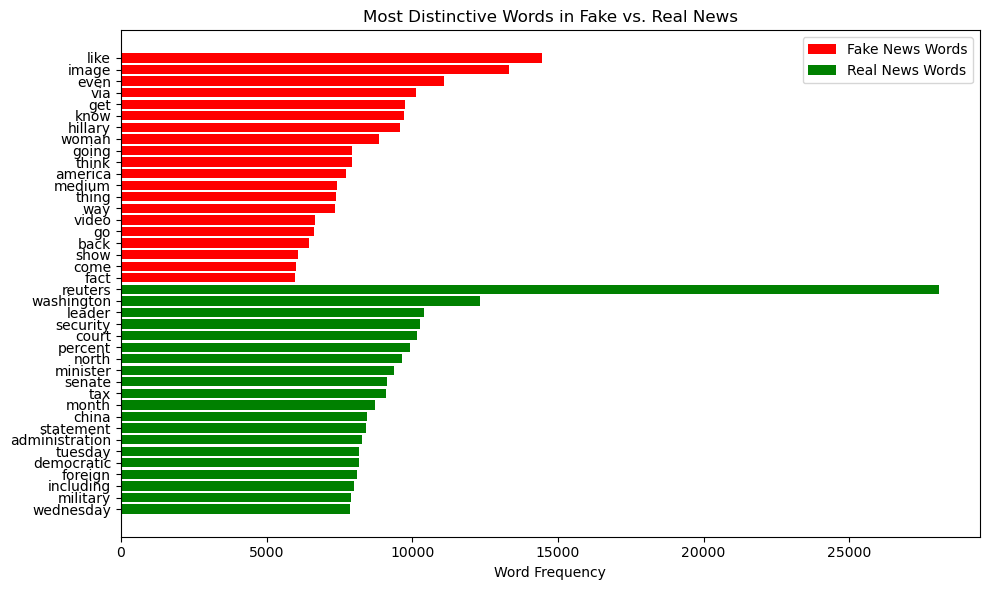

In [ ]:
plot_word_comparison(df, method="count", save_path="./images/word_comparison_raw.png", top_n=10, ngram_range=(1, 3)) 

### Plot highest ranking words by TF-IDF for real and fake news

Chart saved to ./images/word_comparison_normalized.png


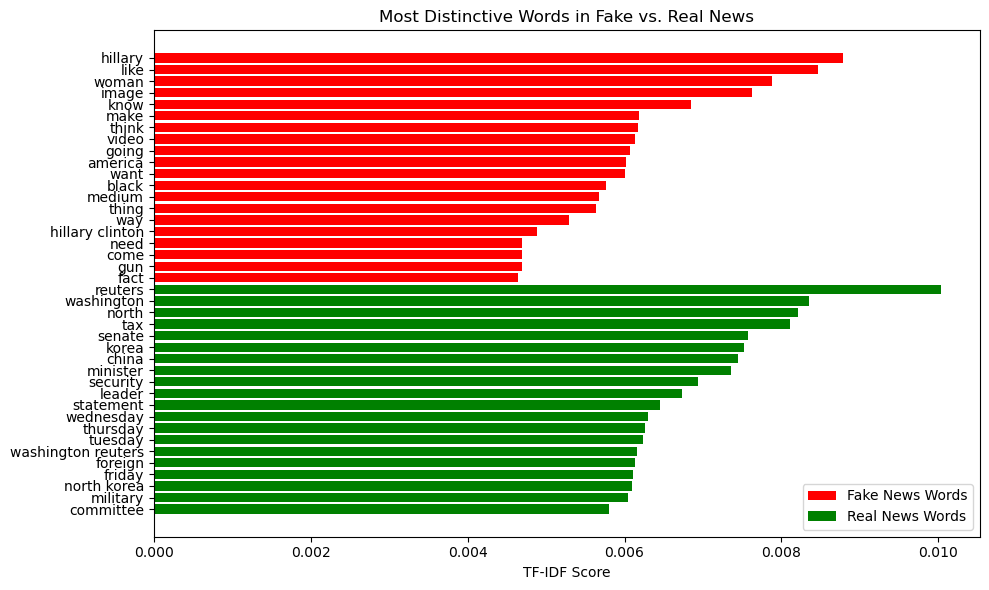

In [ ]:
plot_word_comparison(df, method="tfidf", save_path="./images/word_comparison_normalized.png", top_n=10, ngram_range=(1, 3))

# Train-Test Split
We split the data into training and testing sets. The training set will be used to train the model, while the testing set will be used to evaluate its performance.

In [72]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"])

# Baseline Model (TF-IDF + Logistic Regression)
We will start by building a simple baseline model using TF-IDF (Term Frequency-Inverse Document Frequency) to vectorize the text data and Logistic Regression as the classifier. This will give us a benchmark to compare more advanced models against.

## Feature Extraction
In order to use Logistic Regression, we need to convert the text data into numerical features. We will use the TF-IDF vectorizer to convert the text data into a matrix of TF-IDF features.

## TF-IDF Vectorization
TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. We will use the TF-IDF vectorizer to convert the text data into numerical features.
We will use the TF-IDF vectorizer to convert the text data into numerical features. We will also use the `ngram_range` parameter to include unigrams and bigrams in the feature set.

In [73]:
# Convert text into TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000, 
                                      stop_words="english",
                                   ngram_range=(1,3))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## Train the Logistic Regression Model
Once we have the features extracted and normalized, we can train the Logistic Regression model on the training data.

In [74]:
# train a logistic regression model
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000)

## Evaluating the baseline model
<TODO>

### Predictions

In [75]:
y_pred = logistic_regression.predict(X_test_tfidf)

### Classification Report

In [76]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9844760672703752
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      4239
         1.0       0.99      0.98      0.98      3491

    accuracy                           0.98      7730
   macro avg       0.98      0.98      0.98      7730
weighted avg       0.98      0.98      0.98      7730



### Confusion Matrix

In [77]:
print(confusion_matrix(y_test, y_pred))

[[4197   42]
 [  78 3413]]


## Tuning the Baseline Model

In [78]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid.fit(X_train_tfidf, y_train)

print("Best Params:", grid.best_params_)
print("Best Score:", grid.best_score_)
best_model = grid.best_estimator_

# retrain the model with the best parameters



Best Params: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.9950836119736565


## Baseline Model Evaluation Summary
<TODO>

# Advanced Modeling with Deep Learning (Word2Vec)
<TODO>

## Load pre-trained model
<TODO> Use gensim to load the googlenews vectors pre-trained model

In [79]:
import gensim

model_path = "GoogleNews-vectors-negative300.bin"
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

## Tokenize Text
<TODO> Use the tokenizer to convert the text data into sequences of integers

/Users/rob/micromamba/envs/fake-news/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 89s 181ms/step - accuracy: 0.8993 - loss: 0.2808 - val_accuracy: 0.9807 - val_loss: 0.0968
Epoch 2/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 84s 173ms/step - accuracy: 0.8300 - loss: 0.3286 - val_accuracy: 0.5484 - val_loss: 0.6882
Epoch 3/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 90s 186ms/step - accuracy: 0.6403 - loss: 0.5874 - val_accuracy: 0.9863 - val_loss: 0.0633
Epoch 4/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 89s 184ms/step - accuracy: 0.9875 - loss: 0.0528 - val_accuracy: 0.9943 - val_loss: 0.0283
Epoch 5/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 90s 186ms/step - accuracy: 0.9950 - loss: 0.0291 - val_accuracy: 0.9948 - val_loss: 0.0255
Epoch 6/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 87s 179ms/step - accuracy: 0.9954 - loss: 0.0277 - val_accuracy: 0.9950 - val_loss: 0.0265
Epoch 7/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 93s 193ms/step - accuracy: 0.9951 - loss: 0.0286 - val_accuracy: 0.9953 - val_loss: 0.0243
Epoch 8/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 89s 184ms/step - accuracy: 0.9959 - loss: 0

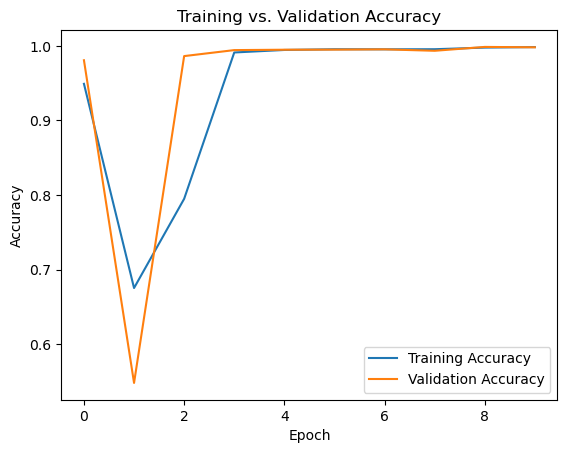

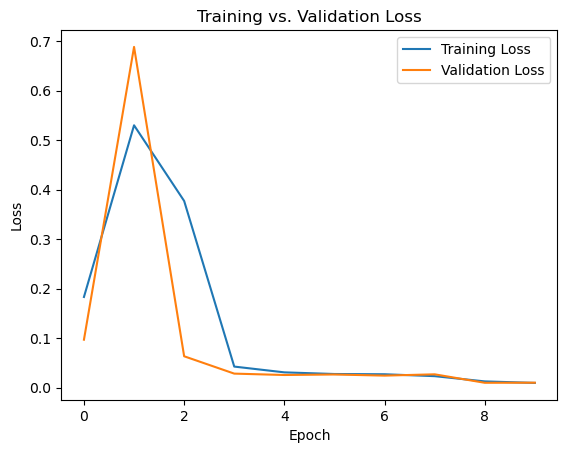

In [80]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Tokenize the text data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text data to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=100, padding="post", truncating="post")

# Create an embedding matrix
embedding_matrix = np.zeros((10000, 300))
for word, index in tokenizer.word_index.items():
    if index < 10000:
        try:
            embedding_vector = word2vec_model[word]
            embedding_matrix[index] = embedding_vector
        except KeyError:
            pass
        
# Create an LSTM model
model = Sequential()
model.add(Embedding(10000, 300, weights=[embedding_matrix], input_length=100, trainable=False))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

# Define early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=3)

# Train the model
history = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=10, batch_size=64, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Loss: {loss:.3f}")
print(f"Test Accuracy: {accuracy:.3f}")

# Plot the training history
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")

plt.title("Training vs. Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("Training vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()





